In [ ]:
import pandas as pd
data = pd.read_csv('MarketPricePrediction.csv')
data.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
0,ABOHAR(PB),January,2005,2350,404,493,446,PB,ABOHAR,January-2005
1,ABOHAR(PB),January,2006,900,487,638,563,PB,ABOHAR,January-2006
2,ABOHAR(PB),January,2010,790,1283,1592,1460,PB,ABOHAR,January-2010
3,ABOHAR(PB),January,2011,245,3067,3750,3433,PB,ABOHAR,January-2011
4,ABOHAR(PB),January,2012,1035,523,686,605,PB,ABOHAR,January-2012


In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# Check for missing values
missing_values = data.isnull().sum()

# Handle missing values if any (fill with mean or drop, depending on the context)
data[['quantity', 'priceMin', 'priceMax', 'priceMod']] = data[['quantity', 'priceMin', 'priceMax', 'priceMod']].fillna(data[['quantity', 'priceMin', 'priceMax', 'priceMod']].mean())


# Encode categorical variables
le_market = LabelEncoder()
data['market'] = le_market.fit_transform(data['market'])

le_state = LabelEncoder()
data['state'] = le_state.fit_transform(data['state'])

le_city = LabelEncoder()
data['city'] = le_city.fit_transform(data['city'])

# Convert 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'], format='%B-%Y')

# Normalize the data
scaler = MinMaxScaler()
data[['quantity', 'priceMin', 'priceMax', 'priceMod']] = scaler.fit_transform(data[['quantity', 'priceMin', 'priceMax', 'priceMod']])

# Create lagged features
data['quantity_lag1'] = data['quantity'].shift(1)
data['priceMin_lag1'] = data['priceMin'].shift(1)
data['priceMax_lag1'] = data['priceMax'].shift(1)
data['priceMod_lag1'] = data['priceMod'].shift(1)

# Drop rows with NaN values created by shifting
data.dropna(inplace=True)

# Select relevant columns for features and target
features = ['quantity_lag1', 'priceMin_lag1', 'priceMax_lag1', 'priceMod_lag1']
target = ['quantity', 'priceMin', 'priceMax', 'priceMod']

X = data[features].values
y = data[target].values

# Reshape data to 3D for LSTM: (samples, timesteps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

data.head()


,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date,quantity_lag1,priceMin_lag1,priceMax_lag1,priceMod_lag1
3,0,January,2011,0.000137,0.509860,0.447993,0.530538,16,0,2011-01-01,0.000470,0.211731,0.179819,0.218354
4,0,January,2012,0.000619,0.084726,0.067230,0.083070,16,0,2012-01-01,0.000137,0.509860,0.447993,0.530538
5,0,January,2013,0.000400,0.219084,0.218094,0.241297,16,0,2013-01-01,0.000619,0.084726,0.067230,0.083070
6,0,January,2014,0.000256,0.168616,0.166025,0.186076,16,0,2014-01-01,0.000400,0.219084,0.218094,0.241297
7,0,January,2015,0.000784,0.216076,0.212874,0.242563,16,0,2015-01-01,0.000256,0.168616,0.166025,0.186076


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(4))  # Output layer for 4 target variables
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=4, validation_split=0.2, verbose=1)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')


Epoch 1/100
1636/1636 [==============================] - 7s 3ms/step - loss: 0.0104 - val_loss: 0.0099
Epoch 2/100
1636/1636 [==============================] - 6s 4ms/step - loss: 0.0094 - val_loss: 0.0095
Epoch 3/100
1636/1636 [==============================] - 5s 3ms/step - loss: 0.0092 - val_loss: 0.0095
Epoch 4/100
1636/1636 [==============================] - 6s 3ms/step - loss: 0.0092 - val_loss: 0.0094
Epoch 5/100
1636/1636 [==============================] - 6s 4ms/step - loss: 0.0091 - val_loss: 0.0094
Epoch 6/100
1636/1636 [==============================] - 5s 3ms/step - loss: 0.0091 - val_loss: 0.0095
Epoch 7/100
1636/1636 [==============================] - 6s 4ms/step - loss: 0.0091 - val_loss: 0.0093
Epoch 8/100
1636/1636 [==============================] - 4s 3ms/step - loss: 0.0091 - val_loss: 0.0094
Epoch 9/100
1636/1636 [==============================] - 5s 3ms/step - loss: 0.0091 - val_loss: 0.0093
Epoch 10/100
1636/1636 [==============================] - 6s 4ms/step - l

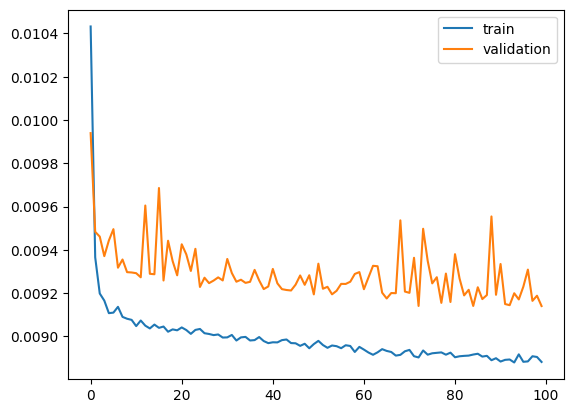

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()


In [ ]:
predictions = model.predict(X_test)
predictions_original_scale = scaler.inverse_transform(predictions)
y_test_original_scale = scaler.inverse_transform(y_test)


64/64 [==============================] - 1s 2ms/step


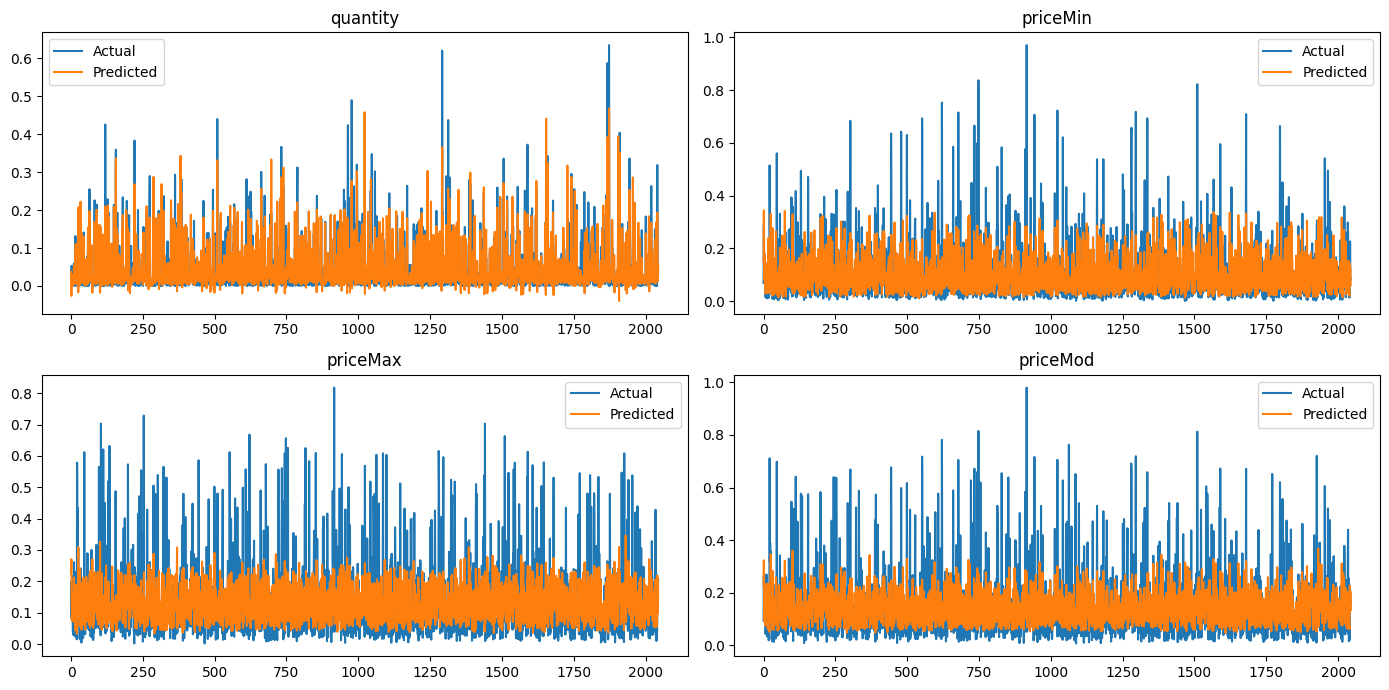

Predicted: [0.03742996 0.1497154  0.22480762 0.22592445], Actual: [0.03857507 0.06918449 0.09494221 0.09382911]
Predicted: [-0.02606953  0.34438547  0.27039176  0.3232841 ], Actual: [0.01275769 0.28760027 0.19995029 0.26313291]
Predicted: [0.00852551 0.17699058 0.13124853 0.1670922 ], Actual: [0.05320766 0.08539439 0.08089971 0.09193038]
Predicted: [0.02870569 0.0797114  0.07398014 0.09317981], Actual: [0.00718726 0.12583556 0.11221573 0.13117089]
Predicted: [0.01383417 0.17797217 0.16071224 0.18927337], Actual: [0.00912745 0.1684492  0.21759662 0.22484177]


In [ ]:
# Plot predictions vs actual values
plt.figure(figsize=(14, 7))

# Plot each feature separately for clarity
for i, col in enumerate(target):
    plt.subplot(2, 2, i + 1)
    plt.plot(y_test_original_scale[:, i], label='Actual')
    plt.plot(predictions_original_scale[:, i], label='Predicted')
    plt.title(col)
    plt.legend()

plt.tight_layout()
plt.show()

# Display a few predictions vs actual values for reference
for i in range(5):
    print(f'Predicted: {predictions_original_scale[i]}, Actual: {y_test_original_scale[i]}')